## Code processing satelite image time for one time step

## Step 1: Data Preparation
Load and Preprocess Data:
Use rasterio to read the Landsat and reference classified images.
Divide the Landsat image and the reference classified image into patches of size 256x256.

In [23]:
# import numpy as np
# import rasterio
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split

# # Function to read a tiff image
# def read_tiff(file_path):
#     with rasterio.open(file_path) as src:
#         image = src.read()
#         image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)
#     return image

# # Load Landsat image and reference classified image
# landsat_image = read_tiff('Images/Landsat_2021.tif')  # Shape: (H, W, 5)
# reference_image = read_tiff('Final_Reference_data.tif')  # Shape: (H, W)
# # Divide the images into patches
# patch_size = 256
# patches_landsat = []
# patches_reference = []

# for i in range(0, landsat_image.shape[0], patch_size):
#     for j in range(0, landsat_image.shape[1], patch_size):
#         patch_landsat = landsat_image[i:i+patch_size, j:j+patch_size, :]
#         patch_reference = reference_image[i:i+patch_size, j:j+patch_size]
#         if patch_landsat.shape[:2] == (patch_size, patch_size):
#             patches_landsat.append(patch_landsat)
#             patches_reference.append(patch_reference)

# patches_landsat = np.array(patches_landsat)
# patches_reference = np.array(patches_reference)

# # Encode reference classes
# label_encoder = LabelEncoder()
# patches_reference = label_encoder.fit_transform(patches_reference.flatten()).reshape(patches_reference.shape)

# # Split Data
# X_train, X_test, y_train, y_test = train_test_split(patches_landsat, patches_reference, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [1]:
import numpy as np
import rasterio
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import mode

# Function to read a tiff image
def read_tiff(file_path):
    with rasterio.open(file_path) as src:
        image = src.read()
        image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)
    return image

# Load Landsat image and reference classified image
landsat_image = read_tiff('Images/Landsat_2021.tif')  # Shape: (H, W, 5)
reference_image = read_tiff('Final_Reference_data.tif')  # Shape: (H, W)

# Divide the images into patches
patch_size = 256
patches_landsat = []
patches_reference = []

for i in range(0, landsat_image.shape[0], patch_size):
    for j in range(0, landsat_image.shape[1], patch_size):
        patch_landsat = landsat_image[i:i+patch_size, j:j+patch_size, :]
        patch_reference = reference_image[i:i+patch_size, j:j+patch_size]
        if patch_landsat.shape[:2] == (patch_size, patch_size):
            patches_landsat.append(patch_landsat)
            patches_reference.append(mode(patch_reference.flatten())[0])  # Get the most frequent class in the patch

patches_landsat = np.array(patches_landsat)
patches_reference = np.array(patches_reference).flatten()

# Encode reference classes
label_encoder = LabelEncoder()
patches_reference = label_encoder.fit_transform(patches_reference)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(patches_landsat, patches_reference, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## Split Data:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(patches_landsat, patches_reference, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## Step 2: Model Definition

Define the Hybrid Transformer Model: Use a combination of Convolutional Neural Networks (CNN) and Transformer layers.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the Hybrid Transformer Model
def hybrid_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # CNN part
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten and prepare for Transformer
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)

    # Compute the reshape dimensions
    reshape_dim = x.shape[-1] // 512
    x = layers.Reshape((reshape_dim, 512))(x)  # Reshape for transformer input

    # Transformer part
    transformer_block = TransformerBlock(embed_dim=512, num_heads=8, ff_dim=2048)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Output
    outputs = layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = hybrid_transformer_model((patch_size, patch_size, 5))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [3]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 5)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   134,218,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 1, 512)         │    10,503,168 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,095,941 (553.50 MB)

 Trainable params: 145,095,941 (553.50 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5969 - loss: 2.9031 - val_accuracy: 0.8182 - val_loss: 0.5154
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8335 - loss: 0.5021 - val_accuracy: 0.8182 - val_loss: 0.5268
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8478 - loss: 0.4716 - val_accuracy: 0.8182 - val_loss: 0.5866
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7635 - loss: 0.5418 - val_accuracy: 0.8182 - val_loss: 0.4731
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8624 - loss: 0.4258 - val_accuracy: 0.8182 - val_loss: 0.4784
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8462 - loss: 0.4511 - val_accuracy: 0.8182 - val_loss: 0.4847
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8755 - loss: 0.4719 - val_accuracy: 0.8182 - val_loss: 0.6406
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8019 - loss: 0.5205 - val_accuracy: 0.8182 - val_loss:

In [6]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')




5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.9464 - loss: 0.3751
Test Accuracy: 93.42%


In [10]:
# Save the Model with a Different File Name
# model.save('hybrid_transformer_model_v2.h5')


In [14]:
# Predict and visualize
predictions = model.predict(patches_landsat)
predicted_classes = np.argmax(predictions, axis=-1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 471ms/step


TypeError: Invalid shape () for image data

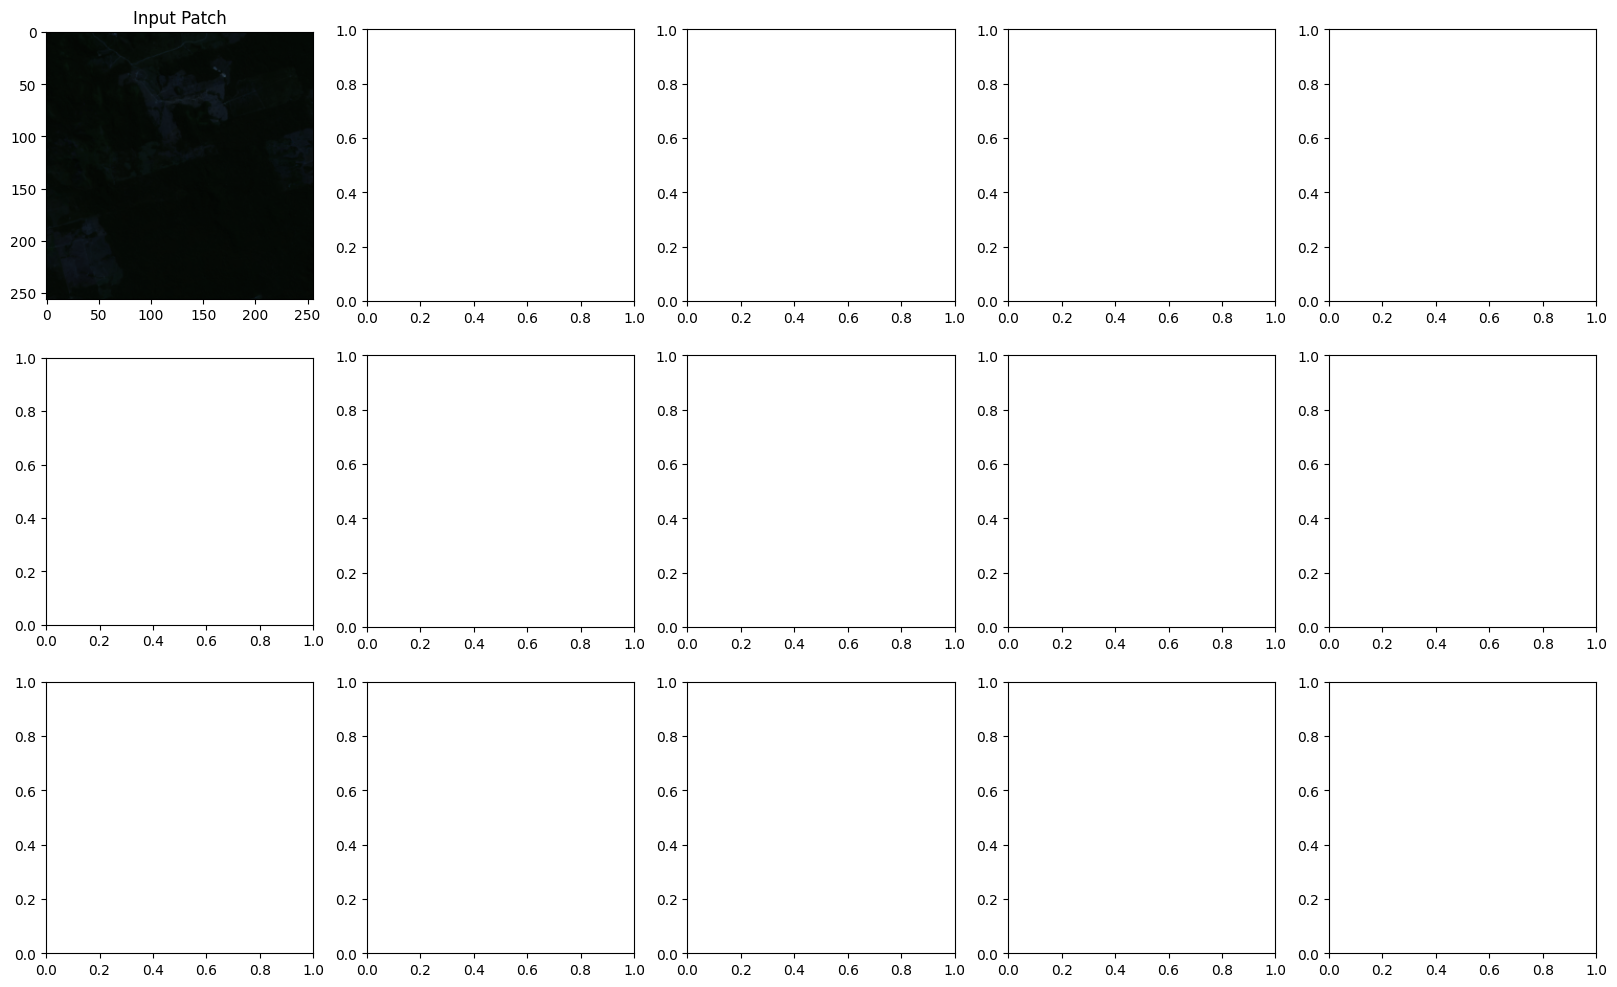

In [15]:
# Display some predictions
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    # Display the input patch
    axes[0, i].imshow(X_test[i, :, :, :3])  # Display the first three channels
    axes[0, i].set_title('Input Patch')

    # Display the predicted classes for the patch
    axes[1, i].imshow(predicted_classes[i], cmap='viridis', vmin=0, vmax=4)  # Display the prediction with a colormap
    axes[1, i].set_title('Predicted Patch')

    # Display the ground truth for the patch
    axes[2, i].imshow(y_test[i], cmap='viridis', vmin=0, vmax=4)  # Display the ground truth with a colormap
    axes[2, i].set_title('Ground Truth Patch')

plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step


TypeError: Invalid shape () for image data

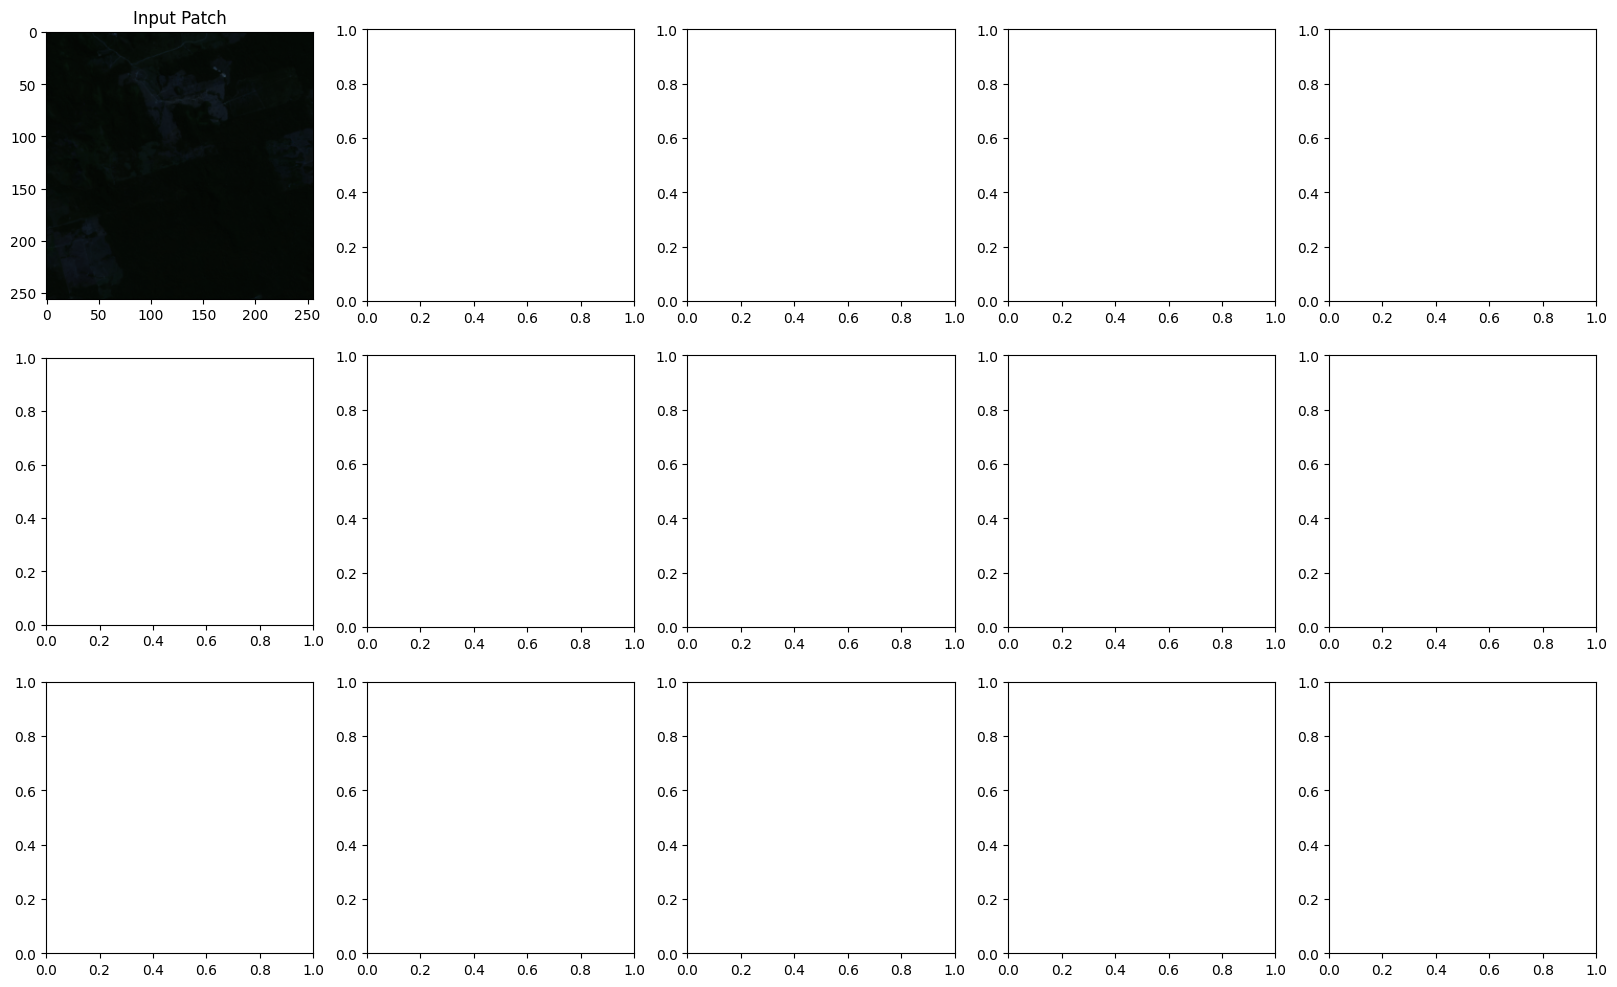

In [9]:
import numpy as np
import rasterio
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Function to read a tiff image
def read_tiff(file_path):
    with rasterio.open(file_path) as src:
        image = src.read()
        image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)
    return image

# Load Landsat image and reference classified image
landsat_image = read_tiff('Images/Landsat_2021.tif')  # Shape: (H, W, 5)
reference_image = read_tiff('Final_Reference_data.tif')  # Shape: (H, W)

# Divide the images into patches
patch_size = 256
patches_landsat = []
patches_reference = []

for i in range(0, landsat_image.shape[0], patch_size):
    for j in range(0, landsat_image.shape[1], patch_size):
        patch_landsat = landsat_image[i:i+patch_size, j:j+patch_size, :]
        patch_reference = reference_image[i:i+patch_size, j:j+patch_size]
        if patch_landsat.shape[:2] == (patch_size, patch_size):
            patches_landsat.append(patch_landsat)
            patches_reference.append(patch_reference)  # Keep the patch as is

patches_landsat = np.array(patches_landsat)
patches_reference = np.array(patches_reference)

# Encode reference classes
label_encoder = LabelEncoder()
patches_reference_flat = label_encoder.fit_transform(patches_reference.flatten())
patches_reference = patches_reference_flat.reshape(patches_reference.shape)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(patches_landsat, patches_reference, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def hybrid_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)



# Predict and visualize
predictions = model.predict(X_test)

# Get the class with the highest probability for each pixel
predicted_classes = np.argmax(predictions, axis=-1)

# Display some predictions
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    # Display the input patch
    axes[0, i].imshow(X_test[i, :, :, :3])  # Display the first three channels
    axes[0, i].set_title('Input Patch')

    # Display the predicted classes for the patch
    axes[1, i].imshow(predicted_classes[i], cmap='viridis', vmin=0, vmax=4)  # Display the prediction with a colormap
    axes[1, i].set_title('Predicted Patch')

    # Display the ground truth for the patch
    axes[2, i].imshow(y_test[i], cmap='viridis', vmin=0, vmax=4)  # Display the ground truth with a colormap
    axes[2, i].set_title('Ground Truth Patch')

plt.tight_layout()
plt.show()


## Code for satelite image time series for one 1 time step

In [12]:
import numpy as np
import rasterio
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Function to read a tiff image
def read_tiff(file_path):
    with rasterio.open(file_path) as src:
        image = src.read()
        image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)
    return image

# Paths to Landsat images and reference classified image
landsat_image_paths = [f'Images/Landsat_{year}.tif' for year in range(2012, 2022)]
reference_image_path = 'Final_Reference_data.tif'

# Load reference classified image
reference_image = read_tiff(reference_image_path)  # Shape: (H, W)

# Initialize lists to hold patches
patch_size = 256
all_patches_landsat = []
all_patches_reference = []

# Loop through each Landsat image
for landsat_image_path in landsat_image_paths:
    landsat_image = read_tiff(landsat_image_path)  # Shape: (H, W, 5)
    for i in range(0, landsat_image.shape[0], patch_size):
        for j in range(0, landsat_image.shape[1], patch_size):
            patch_landsat = landsat_image[i:i+patch_size, j:j+patch_size, :]
            patch_reference = reference_image[i:i+patch_size, j:j+patch_size]
            if patch_landsat.shape[:2] == (patch_size, patch_size):
                all_patches_landsat.append(patch_landsat)
                all_patches_reference.append(mode(patch_reference.flatten())[0])  # Get the most frequent class in the patch

# Convert lists to numpy arrays
all_patches_landsat = np.array(all_patches_landsat)
all_patches_reference = np.array(all_patches_reference).flatten()

# Encode reference classes
label_encoder = LabelEncoder()
all_patches_reference = label_encoder.fit_transform(all_patches_reference)


In [13]:
len(all_patches_landsat)

7560

In [90]:

# Split Data
X_train, X_test, y_train, y_test = train_test_split(all_patches_landsat, all_patches_reference, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


MemoryError: Unable to allocate 14.8 GiB for an array with shape (6048, 256, 256, 5) and data type float64

## Model definition 

In [91]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def hybrid_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # CNN part
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten and prepare for Transformer
    x = layers.Reshape((-1, 256))(x)

    # Transformer part
    transformer_block = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=1024)
    x = transformer_block(x)
    x = layers.Reshape((int(input_shape[0] // 4), int(input_shape[1] // 4), 256))(x)

    # Output
    x = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    outputs = layers.Conv2D(5, (1, 1), activation='softmax', padding='same')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = hybrid_transformer_model((patch_size, patch_size, 5))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


ValueError: The total size of the tensor must be unchanged. Received: input_shape=(1024, 256), target_shape=(64, 64, 256)

In [ ]:
model.summary()

In [ ]:

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val))


In [ ]:

# Save the Model
model.save('hybrid_transformer_model_v2.h5')


In [ ]:

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


In [ ]:

# Predict and visualize
predictions = model.predict(X_test)

# Get the class with the highest probability for each pixel
predicted_classes = np.argmax(predictions, axis=-1)

# Display some predictions
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    # Display the input patch
    axes[0, i].imshow(X_test[i, :, :, :3])  # Display the first three channels
    axes[0, i].set_title('Input Patch')

    # Display the predicted classes for the patch
    axes[1, i].imshow(predicted_classes[i], cmap='tab10', vmin=0, vmax=4)  # Display the prediction with a colormap
    axes[1, i].set_title('Predicted Patch')

    # Display the ground truth for the patch
    axes[2, i].imshow(y_test[i].reshape(patch_size, patch_size), cmap='tab10', vmin=0, vmax=4)  # Display the ground truth with a colormap
    axes[2, i].set_title('Ground Truth Patch')

plt.tight_layout()
plt.show()


### Updated Script to Handle Specific Years
Adjust the List of Image Paths: Update the list to include the specific years 2021, 2019, 2017, 2015, and 2013.
Load and Process the Images: Loop through these specific years, read them, and process them into patches.

In [27]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Function to read a tiff image tile
def read_tiff_tile(file_path, window):
    with rasterio.open(file_path) as src:
        image = src.read(window=window)
        image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)
    return image

# Function to save predictions to a TIFF file
def save_tiff(file_path, data, transform, crs, dtype=rasterio.uint8):
    with rasterio.open(
        file_path,
        'w',
        driver='GTiff',
        height=data.shape[1],
        width=data.shape[2],
        count=1,
        dtype=dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(data, 1)

# Paths to specific Landsat images and reference classified image
specific_years = [2021, 2019, 2017, 2015, 2013]
landsat_image_paths = [f'Images/Landsat_{year}.tif' for year in specific_years]
reference_image_path = 'Final_Reference_data.tif'

# Load reference classified image
reference_image = rasterio.open(reference_image_path)

# Initialize lists to hold patches
patch_size = 256
all_patches_reference = []

# Process the reference image and store patches in memory
for i in range(0, reference_image.height, patch_size):
    for j in range(0, reference_image.width, patch_size):
        window = rasterio.windows.Window(j, i, patch_size, patch_size)
        patch_reference = read_tiff_tile(reference_image_path, window)
        if patch_reference.shape[:2] == (patch_size, patch_size):
            all_patches_reference.append(patch_reference)

# Convert lists to numpy arrays
all_patches_reference = np.array(all_patches_reference).reshape(-1, patch_size, patch_size)

# Encode reference classes
label_encoder = LabelEncoder()
all_patches_reference = label_encoder.fit_transform(all_patches_reference.flatten()).reshape(-1, patch_size, patch_size)


In [28]:

# Ensure the shape for training
X_train, X_test, y_train, y_test = train_test_split(all_patches_reference, all_patches_reference, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [29]:

# Reshape to add channel dimension
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_val = X_val[..., np.newaxis]


In [ ]:

# Define the Transformer block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the hybrid transformer model
def hybrid_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # CNN part
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten and prepare for Transformer
    flatten_shape = (patch_size // 8) * (patch_size // 8) * 256
    x = layers.Reshape((flatten_shape,))(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Reshape((patch_size // 8, patch_size // 8, 512))(x)
    
    # Transformer part
    transformer_block = TransformerBlock(embed_dim=512, num_heads=8, ff_dim=2048)
    x = transformer_block(x)
    
    # Reshape for convolutional layers
    x = layers.Reshape((patch_size // 8, patch_size // 8, 512))(x)

    # Output
    x = layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    outputs = layers.Conv2D(5, (1, 1), activation='softmax', padding='same')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Initialize and compile the model
model = hybrid_transformer_model((patch_size, patch_size, 1))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [37]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 1024, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024, 512)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 1024, 512)      │    10,503,168 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,659,653 (143.66 MB)

 Trainable params: 12,553,217 (47.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,106,436 (95.77 MB)

In [31]:

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val))


Epoch 1/50


ValueError: Cannot take the length of shape with unknown rank.

In [ ]:

# Save the model
model.save('hybrid_transformer_model_v2.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Predict on Landsat patches and save predictions as TIFF files
for landsat_image_path in landsat_image_paths:
    landsat_image = rasterio.open(landsat_image_path)  # Open the image
    predictions = np.zeros((landsat_image.height, landsat_image.width), dtype=np.uint8)
    for i in range(0, landsat_image.height, patch_size):
        for j in range(0, landsat_image.width, patch_size):
            window = rasterio.windows.Window(j, i, patch_size, patch_size)
            patch_landsat = read_tiff_tile(landsat_image_path, window)
            if patch_landsat.shape[:2] == (patch_size, patch_size):
                patch_landsat = np.expand_dims(patch_landsat, axis=0)  # Add batch dimension
                prediction = model.predict(patch_landsat)
                predicted_class = np.argmax(prediction, axis=-1).squeeze()
                predictions[i:i+patch_size, j:j+patch_size] = predicted_class

    # Save the predictions as a TIFF file
    transform = landsat_image.transform
    crs = landsat_image.crs
    prediction_tiff_path = landsat_image_path.replace('.tif', '_prediction.tif')
    save_tiff(prediction_tiff_path, predictions[np.newaxis, :, :], transform, crs)

# Visualize some predictions
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    # Display the input patch
    axes[0, i].imshow(X_test[i].squeeze(), cmap='gray')  # Display the reference patch
    axes[0, i].set_title('Input Patch')

    # Display the predicted classes for the patch
    axes[1, i].imshow(predictions[i], cmap='tab10', vmin=0, vmax=4)  # Display the prediction with a colormap
    axes[1, i].set_title('Predicted Patch')

    # Display the ground truth for the patch
    axes[2, i].imshow(y_test[i].squeeze(), cmap='tab10', vmin=0, vmax=4)  # Display the ground truth with a colormap
    axes[2, i].set_title('Ground Truth Patch')

plt.tight_layout()
plt.show()


In [32]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Function to read a tiff image tile
def read_tiff_tile(file_path, window):
    with rasterio.open(file_path) as src:
        image = src.read(window=window)
        image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)
    return image

# Function to save predictions to a TIFF file
def save_tiff(file_path, data, transform, crs, dtype=rasterio.uint8):
    with rasterio.open(
        file_path,
        'w',
        driver='GTiff',
        height=data.shape[1],
        width=data.shape[2],
        count=1,
        dtype=dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(data, 1)

# Paths to specific Landsat images and reference classified image
specific_years = [2021, 2019, 2017, 2015, 2013]
landsat_image_paths = [f'Images/Landsat_{year}.tif' for year in specific_years]
reference_image_path = 'Final_Reference_data.tif'

# Load reference classified image
reference_image = rasterio.open(reference_image_path)

# Initialize lists to hold patches
patch_size = 256
all_patches_reference = []

# Process the reference image and store patches in memory
for i in range(0, reference_image.height, patch_size):
    for j in range(0, reference_image.width, patch_size):
        window = rasterio.windows.Window(j, i, patch_size, patch_size)
        patch_reference = read_tiff_tile(reference_image_path, window)
        if patch_reference.shape[:2] == (patch_size, patch_size):
            all_patches_reference.append(patch_reference)

# Convert lists to numpy arrays
all_patches_reference = np.array(all_patches_reference).reshape(-1, patch_size, patch_size)

# Encode reference classes
label_encoder = LabelEncoder()
all_patches_reference = label_encoder.fit_transform(all_patches_reference.flatten()).reshape(-1, patch_size, patch_size)


In [33]:

# Ensure the shape for training
X_train, X_test, y_train, y_test = train_test_split(all_patches_reference, all_patches_reference, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [34]:

# Reshape to add channel dimension
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_val = X_val[..., np.newaxis]


In [35]:

# Reshape labels to match output
y_train = y_train[..., np.newaxis]
y_test = y_test[..., np.newaxis]
y_val = y_val[..., np.newaxis]


In [36]:

# Define the Transformer block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the hybrid transformer model
def hybrid_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # CNN part
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten and prepare for Transformer
    flatten_shape = (patch_size // 8) * (patch_size // 8) * 256
    x = layers.Reshape((flatten_shape,))(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Reshape((patch_size // 8, patch_size // 8, 512))(x)
    
    # Transformer part
    transformer_block = TransformerBlock(embed_dim=512, num_heads=8, ff_dim=2048)
    x = transformer_block(x)
    
    # Reshape for convolutional layers
    x = layers.Reshape((patch_size // 8, patch_size // 8, 512))(x)

    # Output
    x = layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    outputs = layers.Conv2D(1, (1, 1), activation='softmax', padding='same')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Initialize and compile the model
model = hybrid_transformer_model((patch_size, patch_size, 1))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


ValueError: The total size of the tensor must be unchanged. Received: input_shape=(512,), target_shape=(32, 32, 512)

In [ ]:

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val))

# Save the model
model.save('hybrid_transformer_model_v2.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Predict on Landsat patches and save predictions as TIFF files
for landsat_image_path in landsat_image_paths:
    landsat_image = rasterio.open(landsat_image_path)  # Open the image
    predictions = np.zeros((landsat_image.height, landsat_image.width), dtype=np.uint8)
    for i in range(0, landsat_image.height, patch_size):
        for j in range(0, landsat_image.width, patch_size):
            window = rasterio.windows.Window(j, i, patch_size, patch_size)
            patch_landsat = read_tiff_tile(landsat_image_path, window)
            if patch_landsat.shape[:2] == (patch_size, patch_size):
                patch_landsat = np.expand_dims(patch_landsat, axis=0)  # Add batch dimension
                prediction = model.predict(patch_landsat)
                predicted_class = np.argmax(prediction, axis=-1).squeeze()
                predictions[i:i+patch_size, j:j+patch_size] = predicted_class

    # Save the predictions as a TIFF file
    transform = landsat_image.transform
    crs = landsat_image.crs
    prediction_tiff_path = landsat_image_path.replace('.tif', '_prediction.tif')
    save_tiff(prediction_tiff_path, predictions[np.newaxis, :, :], transform, crs)

# Visualize some predictions
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    # Display the input patch
    axes[0, i].imshow(X_test[i].squeeze(), cmap='gray')  # Display the reference patch
    axes[0, i].set_title('Input Patch')

    # Display the predicted classes for the patch
    axes[1, i].imshow(predictions[i], cmap='tab10', vmin=0, vmax=4)  # Display the prediction with a colormap
    axes[1, i].set_title('Predicted Patch')

    # Display the ground truth for the patch
    axes[2, i].imshow(y_test[i].squeeze(), cmap='tab10', vmin=0, vmax=4)  # Display the ground truth with a colormap
    axes[2, i].set_title('Ground Truth Patch')

plt.tight_layout()
plt.show()
